## Run RouskinHF

In [1]:
from rouskinhf import convert

data = convert(
    'ct',
    'data/archiveII',
    name='archiveII',
    path_out='data',
    filter=True
)

Parsing ct files: 100%|██████████| 3975/3975 [00:01<00:00, 3267.40it/s]


Over a total of 3975 datapoints, there are:
### OUTPUT
- ALL: 3486 valid datapoints
- INCLUDED: 26 duplicate sequences with different structure / dms / shape
### MODIFIED
- 1537 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 489 duplicate sequences with the same structure / dms / shape


In [7]:
import pandas as pd
data = pd.DataFrame(data).T
data = data[data.sequence.str.len() <=2000]


from rouskinhf import dump_json

dump_json(data.to_dict(orient='index'),
          'data/archiveII.json')

## Visualise



<AxesSubplot: >

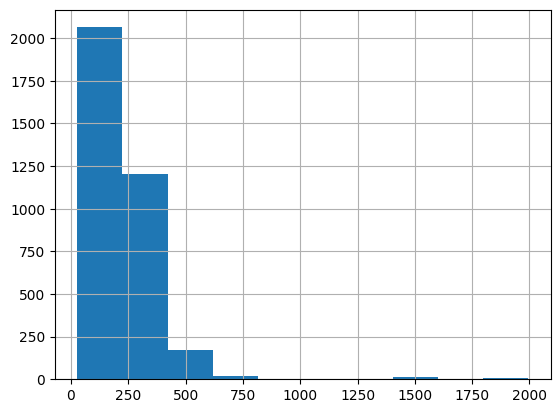

In [8]:
import pandas as pd

df = pd.read_json('data/archiveII.json', orient='index')
df.sequence.apply(len).hist(bins=10)

In [10]:
# Reimport the data
from rouskinhf import convert

data = convert(
    'json',
    'data/archiveII.json',
    name='archiveII',
    path_out='data',
    filter=True,
)

Parsing json file: 100%|██████████| 3481/3481 [00:00<00:00, 123434.89it/s]


Over a total of 3481 datapoints, there are:
### OUTPUT
- ALL: 3481 valid datapoints
- INCLUDED: 26 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


## Upload

In [12]:
from rouskinhf import upload_dataset
import envbash
envbash.load.load_envbash('../.env')

upload_dataset(
    'data/archiveII/data.json',
    commit_message='removed long sequences',
    exist_ok=True
)